<a href="https://colab.research.google.com/github/barauna-lo/Neurocomputing/blob/main/Project_05_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# Project 05 - Recurrent Neuron Network RNN

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)


## PROJETO 5 – Redes Neurais Recoorentes (VAE)

Implementar um modelo LSTM ou GRU para uma das tarefas abaixo:

1. Classificação de série temporais. O modelo deve receber uma
janela temporal (qualquer tipo de dado) e classificar o conteúdo
da janela.

2. Previsão. Treinar um modelo para predizer o valor de uma
variável no instante t+k. O modelo deve receber os dados da
série temporal (instantes anteriores a t – verificar tamanho da
janela) e predizer um favor futuro. k a distância da predição. Por
exemplo, podemos alimentar um modelo com dados de uma
dada empresa (i.e. PETR3) e tentar predizer qual será o valor da
ação daqui 5 dias (k==5)

3. Autoencoder recorrente. O modelo deve mapear a série
temporal na própria série. O objetivo será avaliar como os dados
estão representados no espaço latente

# Project Report

## Introduction 

https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff

https://heartbeat.comet.ml/anomaly-detection-using-lstm-autoencoder-b03289895fef

## Metodology 

## Parametes Explorations

## Datasets

## Plots and Results

## Extras

# Classification Code

## Librarys

In [30]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from scipy import stats
import seaborn as sns

In [66]:
sns.set_style('darkgrid')

## Functions

In [193]:
def plot_user_timeseries(df,id=20,activity='Sitting'):
  user = df[df['user_id']==id]
  plt.subplot(3,1,1)
  plt.plot(user['x_axis'][user['activity']==activity],label='x_axis',color = 'C0')
  plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
  plt.subplot(3,1,2)
  plt.plot(user['y_axis'][user['activity']==activity],label='y_axis',color = 'C1')
  plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
  plt.subplot(3,1,3)
  plt.plot(user['z_axis'][user['activity']==activity],label='z_axis',color = 'C2')
  plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
  

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)



from sklearn.metrics import confusion_matrix
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(10, 8),dpi=100) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      #fmt="d", 
      #cmap=sns.diverging_palette(220, 20, n=7),
      cmap=plt.cm.Blues, fmt='.0f',
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Confusion Matrix')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  # b, t = plt.ylim() # discover the values for bottom and top
  # b += 0.5 # Add 0.5 to the bottom
  # t -= 0.5 # Subtract 0.5 from the top
  # plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

## Data

### DownLoad

In [ ]:
!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz 
!tar -xvf WISDM_ar_latest.tar.gz

In [8]:
column_names = [
  'user_id',
  'activity',
  'timestamp',
  'x_axis',
  'y_axis',
  'z_axis'
]

df = pd.read_csv(
  'WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt',
  header=None,
  names=column_names
)

#The raw file is missing column names. 
#one of the columns is having an extra “;” after each value.

df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)
df.shape

(1098203, 6)

In [211]:
df.columns

Index(['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis'], dtype='object')

In [48]:
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


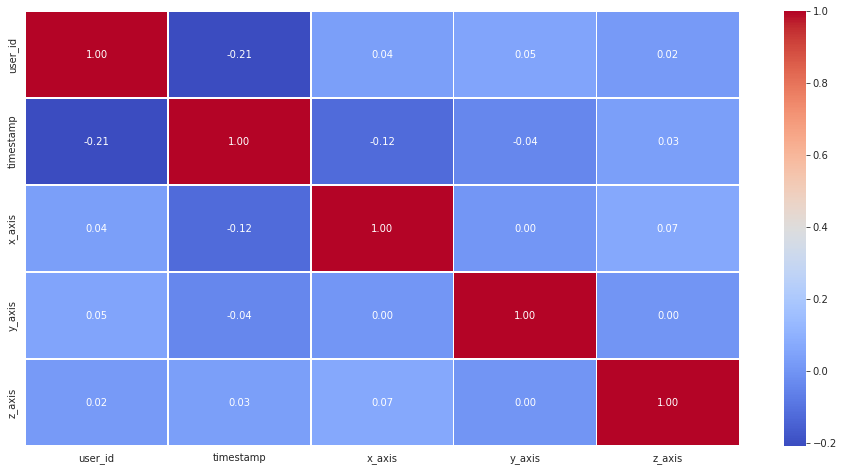

In [215]:
# Let's also draw a heatmap visualization of the correlation matrix

corr_matrix = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Text(0.5, 1.0, 'Data Distribuition')

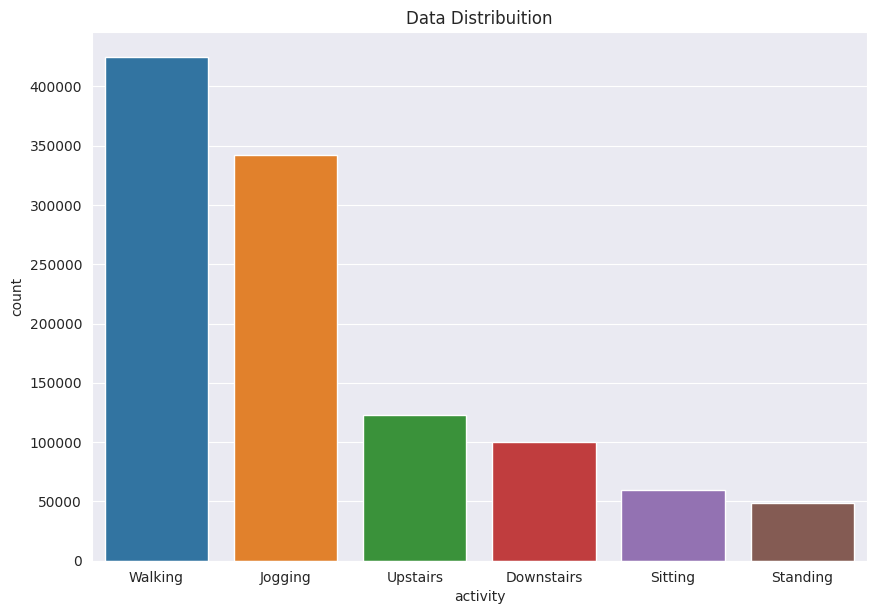

In [150]:
plt.figure(figsize=(10,7),dpi=100)
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index)
plt.title('Data Distribuition')

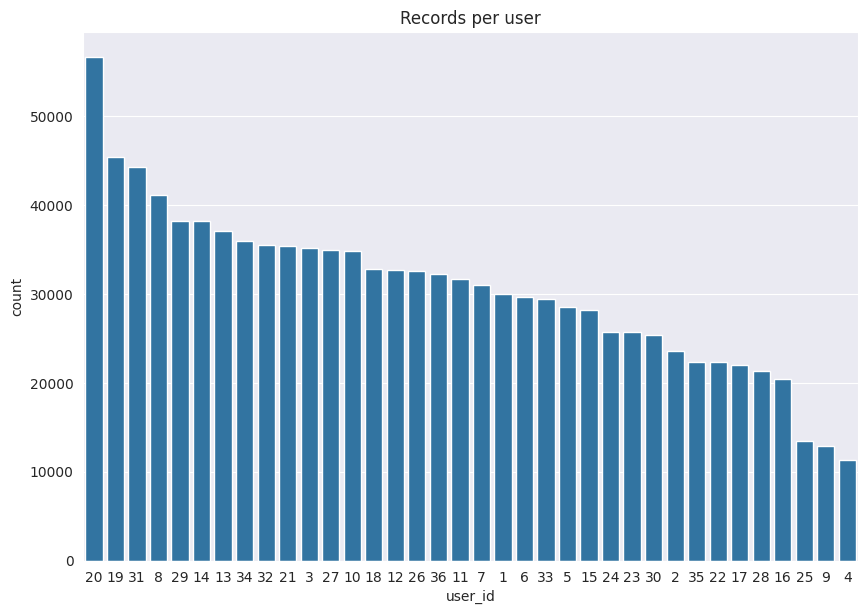

In [152]:
plt.figure(figsize=(10,7),dpi=100)
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

In [201]:
df.activity.unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [220]:
user = df[df['user_id']==20]
print(user[user['activity']== 'Jogging' ].info())
print(user[user['activity']== 'Walking' ].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12948 entries, 21028 to 40434
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    12948 non-null  int64  
 1   activity   12948 non-null  object 
 2   timestamp  12948 non-null  int64  
 3   x_axis     12948 non-null  float64
 4   y_axis     12948 non-null  float64
 5   z_axis     12948 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 708.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13134 entries, 14353 to 33735
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    13134 non-null  int64  
 1   activity   13134 non-null  object 
 2   timestamp  13134 non-null  int64  
 3   x_axis     13134 non-null  float64
 4   y_axis     13134 non-null  float64
 5   z_axis     13134 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 718.3+ KB
Non

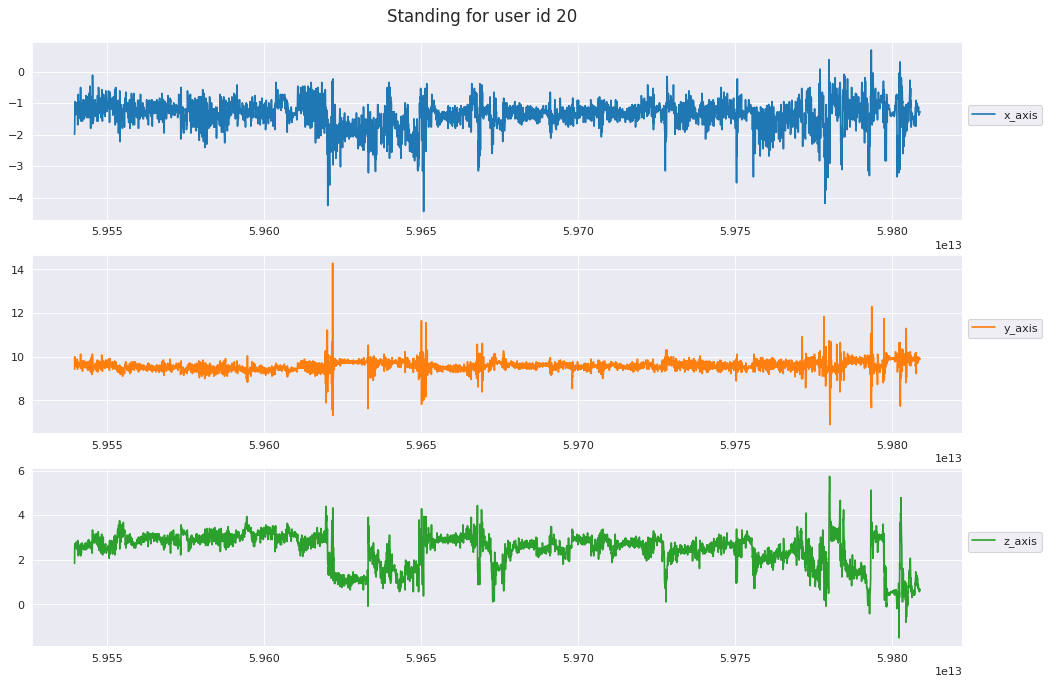

In [205]:
ids = 20
act = "Standing"

plt.figure(figsize=(15,10),dpi=80)
plt.suptitle(f'{act} for user id {ids}',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
plot_timeseries(df,activity=act,id=ids)  
plt.show()

### Preprocessing

In [9]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [ ]:
#scale the accelerometer data values:
scale_columns = ['x_axis', 'y_axis', 'z_axis']
#Creating a Stadiration 
scaler = RobustScaler() 
scaler = scaler.fit(df_train[scale_columns])
df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)

df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

In [17]:
TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']],
    df_train.activity,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']],
    df_test.activity,
    TIME_STEPS,
    STEP
)

In [18]:
print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 1)


In [21]:
#Tranforming each possibility in a binary vector
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

## Model

In [23]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [24]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
632/632 [==============================] - 197s 300ms/step - loss: 1.4633 - acc: 0.5091 - val_loss: 1.2950 - val_acc: 0.5303
Epoch 2/20
632/632 [==============================] - 188s 297ms/step - loss: 1.2081 - acc: 0.5779 - val_loss: 1.0793 - val_acc: 0.6380
Epoch 3/20
632/632 [==============================] - 188s 298ms/step - loss: 1.0042 - acc: 0.6702 - val_loss: 0.9517 - val_acc: 0.7061
Epoch 4/20
632/632 [==============================] - 189s 299ms/step - loss: 0.8392 - acc: 0.7162 - val_loss: 1.2745 - val_acc: 0.6202
Epoch 5/20
632/632 [==============================] - 190s 300ms/step - loss: 0.8095 - acc: 0.7274 - val_loss: 0.7074 - val_acc: 0.7654
Epoch 6/20
632/632 [==============================] - 189s 298ms/step - loss: 0.7325 - acc: 0.7420 - val_loss: 0.7453 - val_acc: 0.7418
Epoch 7/20
632/632 [==============================] - 188s 298ms/step - loss: 0.6793 - acc: 0.7490 - val_loss: 1.2223 - val_acc: 0.7801
Epoch 8/20
632/632 [============================

## Results

In [169]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

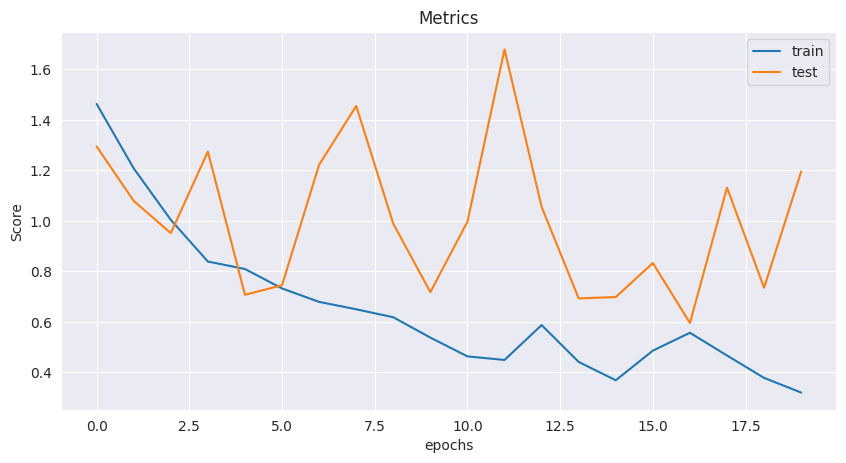

In [172]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Metrics')
plt.ylabel('Score')
plt.xlabel('epochs')
plt.legend();

In [26]:
model.evaluate(X_test, y_test)

156/156 [==============================] - 12s 72ms/step - loss: 1.1447 - acc: 0.7520


[1.1446508169174194, 0.7520031929016113]

In [27]:
y_pred = model.predict(X_test)

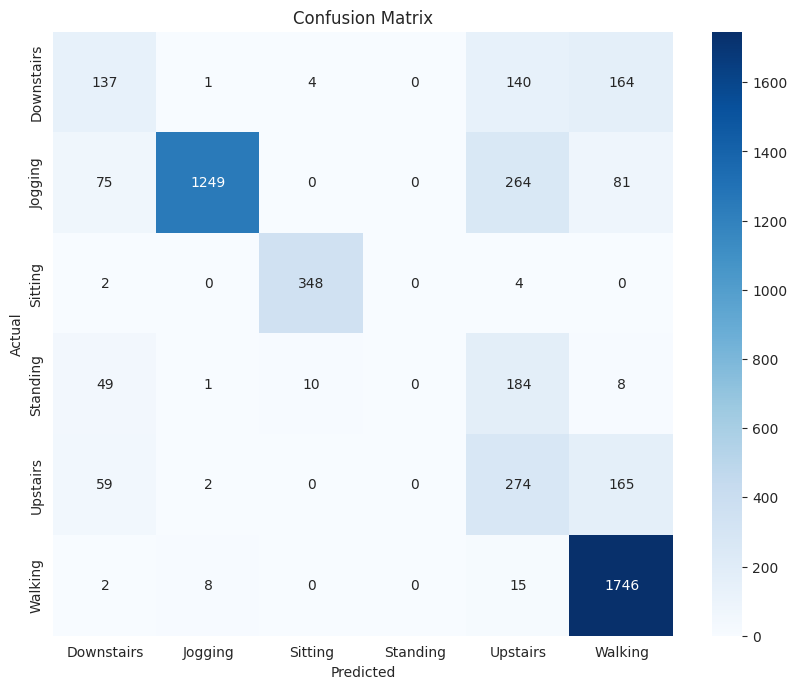

In [192]:
# Its import to explicity the necessity take the inverse of each vector

plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)
plt.show()

# Prediction Code

## Librarys

In [ ]:
import matplotlib as mpl

In [243]:
freq1, freq2, offsets1, offsets2 = np.random.rand(4, 10000, 1)

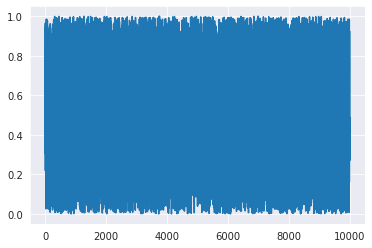

In [246]:
plt.plot(offsets2)

In [252]:
def generate_time_series2(batch_size, n_steps,weigth1=0.5,weigth2=0.2,weigth3=0.1,):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = weigth1 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += weigth2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += weigth3 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [221]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [222]:
# np.random.seed(42)

# n_steps = 50
# series = generate_time_series(10000, n_steps + 1)
# X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
# X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
# X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [282]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")


In [310]:
series.shape

(10000, 51, 1)

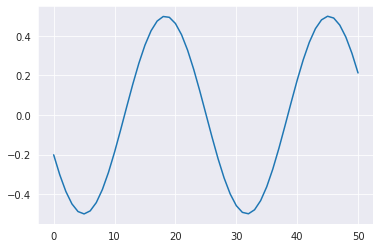

In [309]:
plt.plot(series[0, :, :])

In [295]:
#Generate data
n_steps = 50
series = generate_time_series2(10000, n_steps + 1,weigth2=0,weigth3=0)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

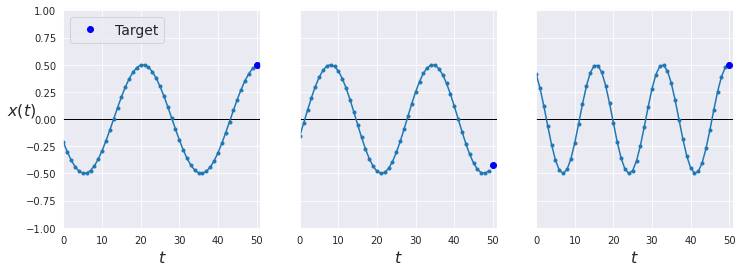

In [285]:

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))

plt.show()

In [276]:
from tensorflow.python import metrics
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

model_pred = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model_pred.compile(loss="mse", optimizer=optimizer)
history = model_pred.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0378 - acc: 0.0000e+00 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0104 - acc: 0.0000e+00 - val_loss: 0.0080 - val_acc: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0069 - acc: 0.0000e+00 - val_loss: 0.0058 - val_acc: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0053 - acc: 0.0000e+00 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0043 - acc: 0.0000e+00 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 8/20
21

In [278]:
model_pred.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 9.8171e-04 - acc: 0.0000e+00


[0.00098171248100698, 0.0]

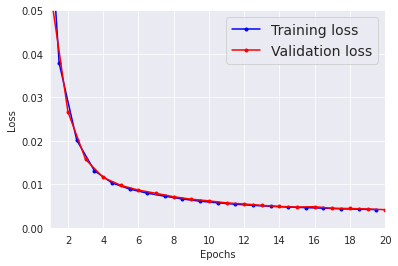

In [283]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history_pred.history["loss"], history_pred.history["val_loss"])
plt.show()

In [284]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

ValueError: ignored

# References

[HAYKIN, Simon. Redes Neurais: Princípios e prática. Porto Alegre
RS:Bookman, 2001.](https://www.amazon.com.br/Redes-Neurais-Princ%C3%ADpios-Simon-Haykin-ebook/dp/B073QSG69Y)

[Data Preprocessing 03: RobustScaler Sklearn| Machine Learning| Python](https://youtu.be/1lCWNcR4iW0)

https://www.kaggle.com/code/szaitseff/classification-of-time-series-with-lstm-rnn/notebook

